In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:33833")
client

<Client: 'tcp://127.0.0.1:33833' processes=8 threads=32, memory=125.87 GiB>

In [2]:
client.restart()

<Client: 'tcp://127.0.0.1:36995' processes=0 threads=0, memory=0 B>

In [2]:
import numpy as np
import xarray as xr
from MITgcmutils import rdmds
from xmitgcm import open_mdsdataset
import os.path as op
import os
from scipy.interpolate import griddata, interp1d
# from multiprocessing import Pool
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/tank/chaocean/qjamet/'
# dir_grd50 = '/tank/spectre/gridMIT_50/'
dir_grd50 = '/tank/spectre/gridMIT_50/smooth_topo/'
dir_aml12 = '/tank/chaocean/atmospheric_conditions_12/'
# dir_aml50 = '/tank/spectre/tuchida/atmo_cond_50'
dir_aml50 = '/tank/spectre/tuchida/SPECTRE/atmo_cond_50/'
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'

In [4]:
iper = 2007
ds12 = open_mdsdataset(op.join(ddir,'RUNS/ORAR/memb%02d/run%4d/ocn/' 
                               % (0,iper)), 
                       grid_dir=gdir,
                       iters=7097760,
                       prefix=['diag_ocnTave'], delta_t=2e2,
                      )
ds12

<xarray.Dataset>
Dimensions:  (time: 1, XC: 1000, YC: 900, XG: 1000, YG: 900, Z: 46, Zp1: 47,
              Zu: 46, Zl: 46)
Coordinates: (12/33)
    iter     (time) int64 7097760
  * time     (time) timedelta64[ns] 16430 days
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) >f4 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * XG       (XG) >f4 262.0 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.8 347.9
  * YG       (YG) >f4 -19.96 -19.87 -19.79 -19.71 ... 54.71 54.79 54.88 54.96
    ...       ...
    maskW    (Z, YC, XG) bool dask.array<chunksize=(46, 900, 1000), meta=np.ndarray>
    maskS    (Z, YG, XC) bool dask.array<chunksize=(46, 900, 1000), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(900, 1000), meta=np.ndarray>
    rhoRef   (Z) >f4 1.021e+03 1.021e+03 1.021e+03 ... 1.044e+03 1.044e+03
    maskInW  (YC, XG) bool dask.array<chunksize=(900, 1000), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(900, 1000), meta=np.ndarray>
Data variables:
    *empty*
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/tank/chaocea...

In [5]:
tmpdir = str('%s/%04i' % (dir_aml50, iper))
if not op.isdir(tmpdir):
    os.makedirs( tmpdir )

#-- some parameters --
#[nr50, ny50, nx50] = [75, 1450, 1850]
[nr12, ny12, nx12] = [46, 900, 1000]
nt  = 1460         # +2 time records for begin/end interp

varN = ['t2', 'q2', 'u10', 'v10', 'radsw', 'radlw', 'precip']
nvar = len(varN)

In [6]:
#------------------------------------------------------------------
#       Make Atmospheric forcing files from our previous 1/12 runs
# -->>  need to update with 6-hourly forcing files from original DFS
#------------------------------------------------------------------
#-- grid params --
# parent and child grid origin are co-localized
rSphere = 6370000.0

#- 1/50 -
x50deg = rdmds(dir_grd50 + 'XC')
y50deg = rdmds(dir_grd50 + 'YC')
[ny50, nx50] = x50deg.shape
xx50 = np.radians(x50deg - x50deg[0,0]) * rSphere * np.cos(np.radians(y50deg))
yy50 = np.radians(y50deg - y50deg[0,0]) * rSphere
#- 1/12 -
x12deg = rdmds(gdir + 'XC')
y12deg = rdmds(gdir + 'YC')
xx12 = np.radians(x12deg - x50deg[0,0]) * rSphere * np.cos(np.radians(y12deg))
yy12 = np.radians(y12deg - y50deg[0,0]) * rSphere  
xy12 = np.zeros([(ny12)*(nx12), 2])
xy12[:, 0] = xx12.reshape([ny12*nx12])
xy12[:, 1] = yy12.reshape([ny12*nx12])

#-- define horizontal interpolation --
def hz_interp(iii):
    if iii % 50 == 0:
        print("Interpolating %s, time: %04i" % (varN[ivar], iii) )
    tmp_interp = griddata(xy12, var12[iii].reshape([ny12*nx12]), (xx50, yy50), 
                          method=mmeth)
    return tmp_interp

In [7]:
for ivar in range(6,nvar):
  #ivar = 6
  #-- input file --
    if varN[ivar] == 'precip' and iper <= 1976:
        f = open( str("%s/precip_climExtd.box" % (dir_aml12) ), 'r')
        var12 = np.fromfile(f, '>f4').reshape([nt+2, ny12, nx12])
        f.close()
    else:
        f = open( str("%s/%04i/%s_%04i.box" % (dir_aml12, iper, varN[ivar], iper) ), 'r')
        var12 = np.fromfile(f, '>f4').reshape([nt+2, ny12, nx12])
        f.close()

  #- hz interp (with parallelization) -
    if varN[ivar] == 'u10' or varN[ivar] == 'v10':
        mmeth='cubic'
    else:
        mmeth='linear'
  #
    # if __name__ == '__main__':
    #     p = Pool(nproc)
    #     tmp_var50 = p.map(hz_interp, np.arange(nt+2))
  #- reshape -
    var50 = np.zeros([nt+2, ny50, nx50])
    for iii in range(nt+2):
        # var50[iii, :, :] = tmp_var50[iii]
        var50[iii] = hz_interp(iii)
  #- save -
    if varN[ivar] == 'precip' and iper <= 1976:
        f = open( str("%s/precip_climExtd.bin" % (dir_aml50) ), 'wb' )
        var50.reshape([(nt+2)*ny50*nx50]).astype('>f4').tofile(f)
        f.close()
    else:
        f = open( str("%s/%04i/%s_%04i.bin" % (dir_aml50, iper, varN[ivar], iper) ), 'wb' )
        var50.reshape([(nt+2)*ny50*nx50]).astype('>f4').tofile(f)
        f.close()
  #
    del var12, var50
    # gc.collect()

Interpolating precip, time: 0000
Interpolating precip, time: 0050
Interpolating precip, time: 0100
Interpolating precip, time: 0150
Interpolating precip, time: 0200
Interpolating precip, time: 0250
Interpolating precip, time: 0300
Interpolating precip, time: 0350
Interpolating precip, time: 0400
Interpolating precip, time: 0450
Interpolating precip, time: 0500
Interpolating precip, time: 0550
Interpolating precip, time: 0600
Interpolating precip, time: 0650
Interpolating precip, time: 0700
Interpolating precip, time: 0750
Interpolating precip, time: 0800
Interpolating precip, time: 0850
Interpolating precip, time: 0900
Interpolating precip, time: 0950
Interpolating precip, time: 1000
Interpolating precip, time: 1050
Interpolating precip, time: 1100
Interpolating precip, time: 1150
Interpolating precip, time: 1200
Interpolating precip, time: 1250
Interpolating precip, time: 1300
Interpolating precip, time: 1350
Interpolating precip, time: 1400
Interpolating precip, time: 1450


In [6]:
iper = 2003
f = open( str("%s/%04i/%s_%04i.bin" % (dir_aml50, iper, varN[1], iper) ), 'r')
qI = np.fromfile(f, '>f4').reshape([nt+2, 1000, 2052])
f.close()

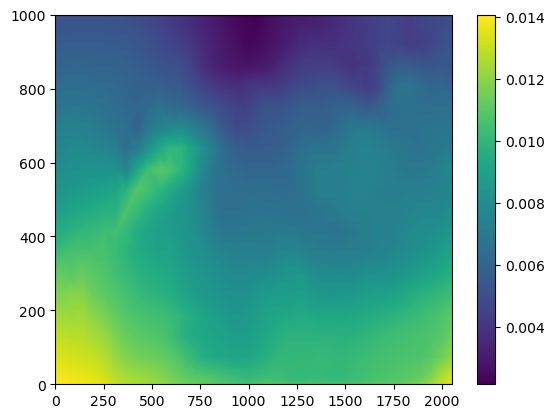

In [8]:
plt.pcolormesh(qI[-1])
plt.colorbar()

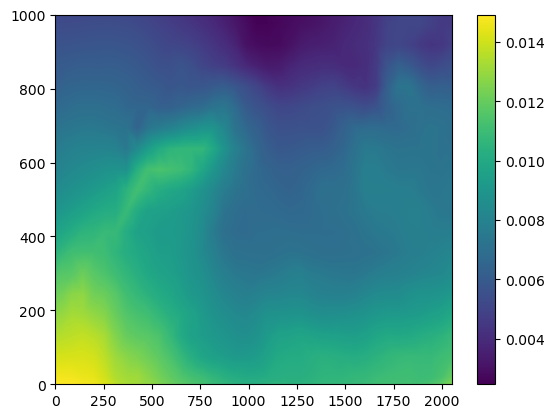

In [7]:
plt.pcolormesh(qI[0])
plt.colorbar()

In [9]:
f = open( str("%s/%04i/%s_%04i.bin" % (dir_aml50, iper, varN[0], iper) ), 'r')
tI = np.fromfile(f, '>f4').reshape([nt+2, 1000, 2052])
f.close()

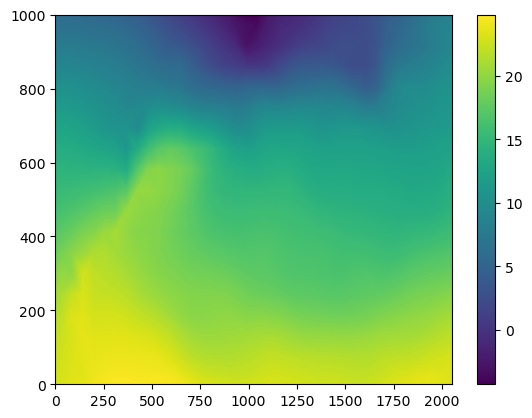

In [10]:
plt.pcolormesh(tI[-1])
plt.colorbar()

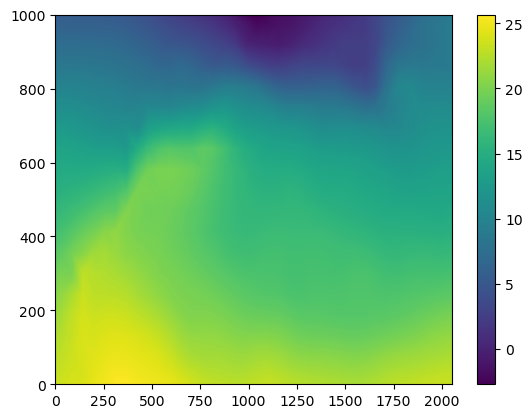

In [11]:
plt.pcolormesh(tI[0])
plt.colorbar()

In [16]:
f = open( str("%s/%04i/%s_%04i.bin" % (dir_aml50, iper, varN[2], iper) ), 'r')
uI = np.fromfile(f, '>f4').reshape([nt+2, 1000, 2052])
f.close()

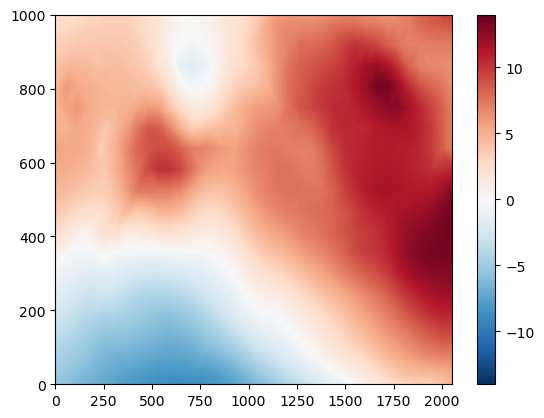

In [19]:
plt.pcolormesh(uI[-1], cmap='RdBu_r', vmin=-14, vmax=14)
plt.colorbar()

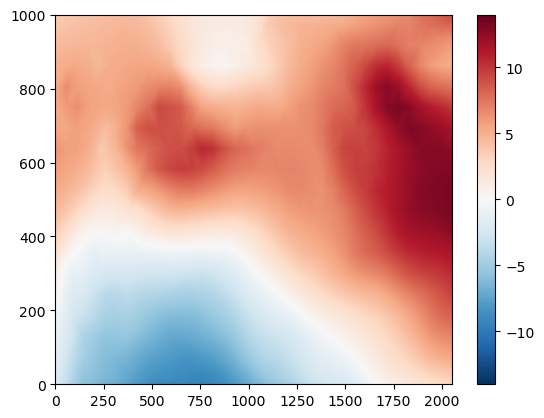

In [21]:
plt.pcolormesh(uI[0], cmap='RdBu_r', vmin=-14, vmax=14)
plt.colorbar()

In [22]:
f = open( str("%s/%04i/%s_%04i.bin" % (dir_aml50, iper, varN[3], iper) ), 'r')
vI = np.fromfile(f, '>f4').reshape([nt+2, 1000, 2052])
f.close()

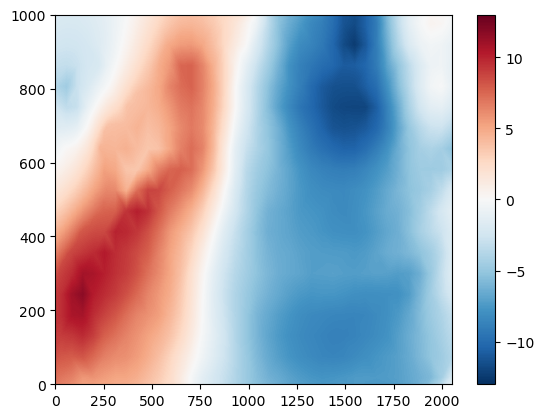

In [25]:
plt.pcolormesh(vI[-1], cmap='RdBu_r', vmin=-13, vmax=13)
plt.colorbar()

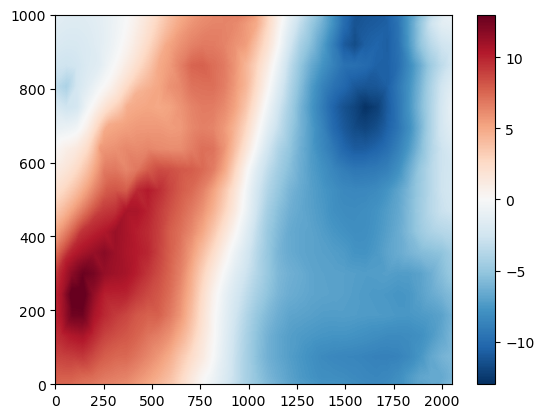

In [26]:
plt.pcolormesh(vI[0], cmap='RdBu_r', vmin=-13, vmax=13)
plt.colorbar()